In [1]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
rng = np.random.default_rng(729)

In [45]:
def match_formation(party_size, arrivals, match_size=5):
    arrival_time = np.cumsum(arrivals)
    n = len(party_size)

    open_lobbies = []  
    filled = []        
    party_wait = np.full(n, np.nan)
    lobby_waits = []          
    individual_wait = []      

    for i, size in enumerate(party_size):
        
        
        best_j = None
        best_remaining = None

        for j, lob in enumerate(open_lobbies):
            if lob["load"] + size > match_size:
                continue
            remaining = match_size - (lob["load"] + size)
            if best_j is None or remaining < best_remaining:
                best_j = j
                best_remaining = remaining

        
        if best_j is None:
            open_lobbies.append({"idx": [i], "sizes": [size], "load": size, "start": arrival_time[i]})
            if size == match_size:
                lob = open_lobbies.pop()
                filled.append({"idx": lob["idx"], "sizes": lob["sizes"], "start": lob["start"], "fill": arrival_time[i]})
            continue

        lob = open_lobbies[best_j]
        lob["idx"].append(i)
        lob["sizes"].append(size)
        lob["load"] += size

        if lob["load"] == match_size:
            filled.append({"idx": lob["idx"], "sizes": lob["sizes"], "start": lob["start"], "fill": arrival_time[i]})
            open_lobbies.pop(best_j)

    filled_sorted = sorted(filled, key=lambda d: d["start"])

    filled_lobbies_sizes = [d["sizes"] for d in filled_sorted]
    open_lobbies_sizes = [lob["sizes"] for lob in open_lobbies]

    lobby_waits = []
    for d in filled_sorted:
        fill_time = d["fill"]
        lobby_waits.append(fill_time - d["start"])
        for p in d["idx"]:
            w = fill_time - arrival_time[p]
            party_wait[p] = w
            individual_wait.extend([w] * int(party_size[p]))

    return {
        "filled_lobbies": filled_lobbies_sizes,   
        "open_lobbies": open_lobbies_sizes,       
        "lobby_waits": np.array(lobby_waits, float),
        "party_wait": party_wait,
        "individual_wait": np.array(individual_wait, float),
    }


In [46]:
N = 1000
sizes = np.random.randint(1, 6, size=N)
arrivals = rng.uniform(0, 5, size=N)

In [52]:
fill_queue = match_formation(sizes, arrivals)
avg_wt = fill_queue["lobby_waits"]

count    584.000000
mean     103.506931
std       95.748172
min        0.000000
25%        0.000000
50%       91.597516
75%      195.436367
max      298.470018
dtype: float64

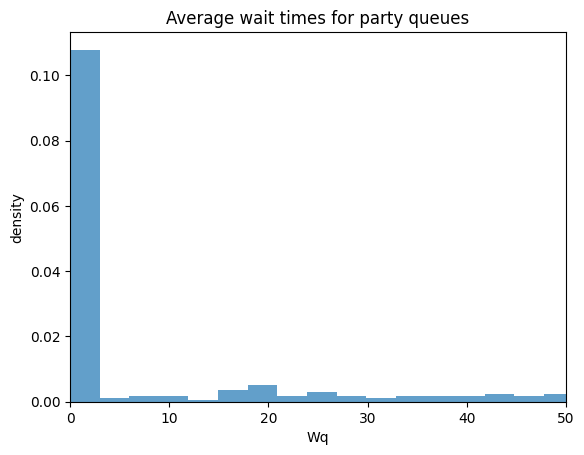

In [53]:
plt.figure()
plt.hist(avg_wt, bins=100, density=True, alpha=0.7)
plt.xlabel("Wq"); plt.ylabel("density"); plt.title("Average wait times for party queues")
plt.xlim(0, 50)

s = pd.Series(avg_wt)
s.describe()

In [42]:
N = 1000
means = []
medians = []

for i in range(100):
    arrivals = rng.uniform(0, 5, size=N)
    sizes = np.random.randint(1, 6, size=N)
    
    fill = match_formation(sizes, arrivals)
    
    avg_wt = fill["lobby_waits"]
    s = pd.Series(avg_wt)
    
    means.append(s.describe()[1])    # [1] is the mean
    medians.append(s.describe()[5])  # [5] is the median

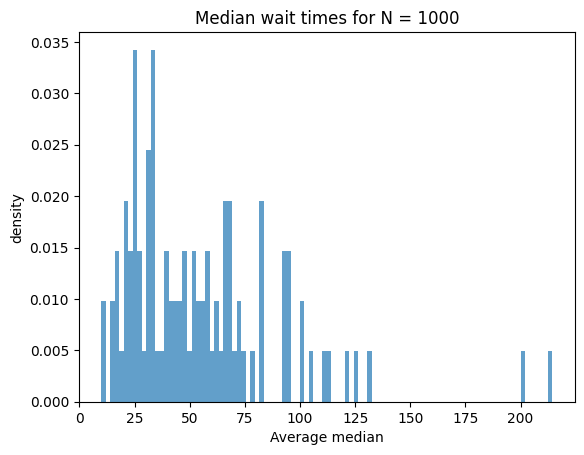

In [43]:
# median
plt.figure()
plt.hist(medians, bins=100, density=True, alpha=0.7)
plt.xlabel("Average median")
plt.ylabel("density")
plt.title("Median wait times for N = 1000")
plt.show()

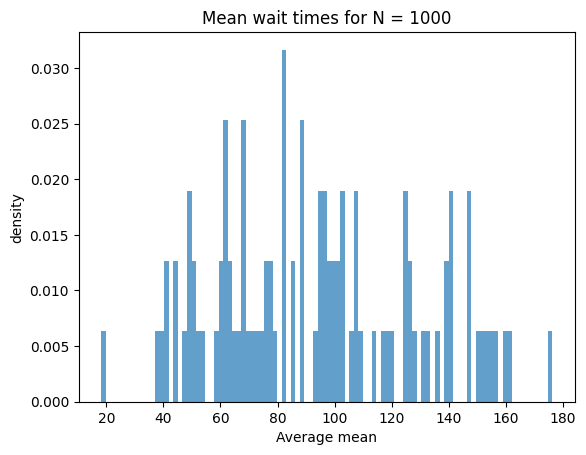

In [44]:
# mean
plt.figure()
plt.hist(means, bins=100, density=True, alpha=0.7)
plt.xlabel("Average mean")
plt.ylabel("density")
plt.title("Mean wait times for N = 1000")
plt.show()

In [49]:
def Poissondist(N, lmb):
    arr = rng.poisson(lmb, size=N)
    for i in range(N):
        if arr[i] == 0:
            arr[i] = 1
        if arr[i] > 5:
            arr[i] = rng.choice([1,2,3,4,5])
    return arr

Text(0.5, 1.0, 'Individual Wait in Queue: (Poisson Party Size)')

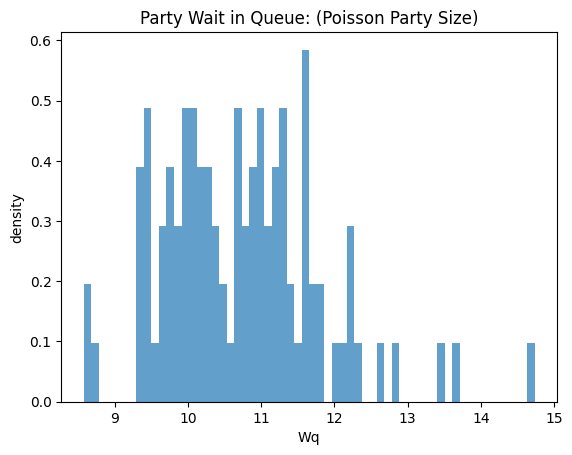

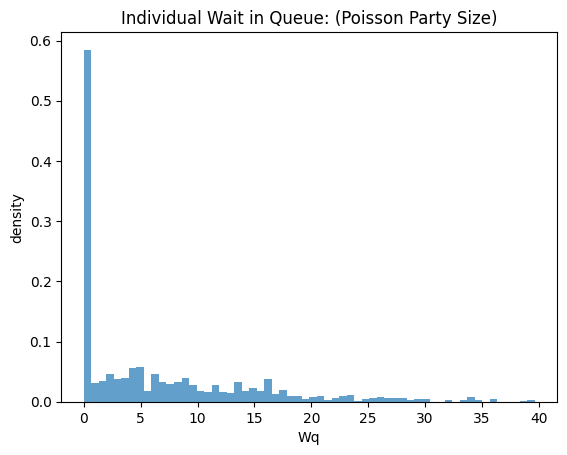

In [54]:
N = 1000
means = []
medians = []
individual_wt = []

for i in range(100):
    arrivals = rng.uniform(0, 5, size=N)
    sizes = Poissondist(N, 2)
    
    fill = match_formation(sizes, arrivals)
    
    avg_wt = fill['lobby_waits']
    s = pd.Series(avg_wt)
    means.append(s.describe()[1])    
    medians.append(s.describe()[5])

    individual_wt = fill['individual_wait']
plt.figure()
plt.hist(means, bins=60, density=True, alpha=0.7)
plt.xlabel("Wq"); plt.ylabel("density"); plt.title("Party Wait in Queue: (Poisson Party Size)")

plt.figure()
plt.hist(individual_wt, bins=60, density=True, alpha=0.7)
plt.xlabel("Wq"); plt.ylabel("density"); plt.title("Individual Wait in Queue: (Poisson Party Size)")